In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import chardet
import glob
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import sys
import cfunits

# import custom modules
sys.path.append('../scripts')
import funcs

---
---
# Table of contents
* [1. Load source data](#load-data)
    * [1.1. Preview headers](#preview-headers)  
* [2. Prepare data headers](#prep-headers)
    * [2.1. Preview headers, descriptions, and units](#view-headers)
    * [2.2. Clean headers, descriptions, and units](#clean-headers)
        * [2.2.1. Units (multi-header index 2)](#units)
        * [2.2.2. Descriptions (multi-header index 1)](#descriptions)
        * [2.2.3. Variables (multi-header index 0)](#variables)
        * [2.2.4. Data values](#data-vals)
* [3. Standardize data headers](#standardizing-steps)
    * [3.1. Copy of filename_headers to filename_headers_lookup](#copy)
    * [3.2. Assign lookup table header names](#assign)
    * [3.3. Use ESS-Dive leaf-gas-exchange standards to create lookup table](#multiheader-standards)
    * [3.4. Load the lookup table](#complete-lookup)
    * [3.5. Use the lookup table to standardize headers](#standardize)
* [4. Data quality control](#qc)
    * [4.1. Strings](#strings)
    * [4.2. Measurememt device](#device)
    * [4.3. Season](#season)
    * [4.4. Plant height](#height)
    * [4.5. Datetimes](#datetimes)
    * [4.6. Species names](#species)
    * [4.7. Create species lookup table](#species-lookup)
    * [4.8. Fill in species lookup table](#fill-species-lookup)
        * [4.8.1. Format headers](#species-lookup-headers)
        * [4.8.2. Merge lookup table with data](#merge)
        * [4.8.3. Drop extra columns](#drop)
* [5. Data unit conversion](#unit-conversion)
    * [5.1. Visualize and confirm unit conversions](#confirm-conversion)
    * [5.2. Drop out-of-range (oor) values](#oor)

---
---
## 1. Load the data <a class="anchor" id="load-data"></a>
NOTE: If certain fancy characters aren't used in a file, an encoder will pick it up as us/ascii even if I've explicitly encoded it as utf-8-sig, and that's fine. UTF-8-SIG just ensures that the .csv is read properly in Excel on a Mac AND a windows computer.

In [3]:
filename = 'kumarathunge_2019'
# ensure readable encoding of summary data (01) and raw curve data (02)
data_path = f'../data/input/{filename}/ACi-TGlob_V1.0.csv'
utf8_data_path = funcs.convert_to_utf8sig(data_path)

# ensure readable encoding of metadata files (01, 02)
metadata_path = f'../data/input/{filename}/ACi-TGlob_V1.0_metadata.csv'
utf8_metadata_path = funcs.convert_to_utf8sig(metadata_path)

Encoding utf-8 was detected for ../data/input/kumarathunge_2019/ACi-TGlob_V1.0.csv.
Converted ../data/input/kumarathunge_2019/ACi-TGlob_V1.0.csv to utf-8-sig and saved as ../data/input/kumarathunge_2019/ACi-TGlob_V1.0_utf8sig.csv
Encoding utf-8 was detected for ../data/input/kumarathunge_2019/ACi-TGlob_V1.0_metadata.csv.
Converted ../data/input/kumarathunge_2019/ACi-TGlob_V1.0_metadata.csv to utf-8-sig and saved as ../data/input/kumarathunge_2019/ACi-TGlob_V1.0_metadata_utf8sig.csv


In [31]:
# read the data
data = pd.read_csv(utf8_data_path, low_memory=False)
metadata = pd.read_csv(utf8_metadata_path, low_memory=False)

In [32]:
# clean up data column names
data.columns = (data.columns.str.strip()
                .str.lower()
                .str.replace(' ', '_'))

In [33]:
# clean up metadata column names
metadata.rename(columns={'Variable':'variable',
                         'Description':'description',
                         'Units':'unit'}, inplace=True)
metadata = metadata[['variable', 'description', 'unit']]
metadata = metadata[metadata['variable'] != 'species'] # header doesnt even exist in data
metadata['variable'] = (metadata['variable'].str.strip()
                        .str.lower()
                        .str.replace(' ', '_'))

In [34]:
# there's an error to fix in the metadata
# lifespan should be leafspan
diff = list(set(data.columns.to_list()) ^ set(metadata['variable'].to_list()))
diff

['leafspan', 'lifespan']

In [35]:
metadata[metadata['variable'] == 'lifespan']

,variable,description,unit
4,lifespan,Evergreen or Deciduous,NaN


In [36]:
metadata['variable'] = metadata['variable'].replace('lifespan', 'leafspan')

---
### 1.1. Preview the data and metadata headers <a class="anchor" id="preview-headers"></a>
If there are no metadata provided, you must create a metadata .csv based on the headers in the data

In [37]:
data.columns

Index(['dataset', 'data_type', 'data_contributor', 'location', 'leafspan',
       'tregion', 'type', 'pft', 'growth_condition', 'species',
       'seed_source_latitude', 'seed_source_longitude', 'season', 'date',
       'temp_treatment', 'co2_treatment', 'chamber', 'water_treatment',
       'leaf_age', 'replicate', 'curve_id', 'curve_number', 'photo', 'cond',
       'ci', 'vpdl', 'tair', 'tleaf', 'tblk', 'co2r', 'co2s', 'pari', 'mat',
       'maxt', 'mgdd0', 'reference'],
      dtype='object')

In [38]:
metadata.head(3)

,variable,description,unit
0,dataset,unique name given for individual datasets,NaN
1,data_type,data grouping tag,ACi-T: ACi temperature response data; An-T: te...
2,data_contributor,name of the individual dataset contributors,NaN


---
---
## 2. Prepare data headers <a class="anchor" id="prep-headers"></a>
Add variable/description/units to as a 3-row multi-header

In [39]:
# merge metadata with data column names
columns_df = pd.DataFrame({'variable': data.columns})
matched_metadata = columns_df.merge(metadata, on='variable', how='left')

# check for unmatched variables
unmatched = matched_metadata[matched_metadata['description'].isnull()]
if not unmatched.empty:
    print("Warning: Some columns in the data file do not match the metadata:")
    print(unmatched)

In [40]:
# drop unmatched variables
matched_metadata = matched_metadata.dropna(subset=['description', 'unit'])
data = data[matched_metadata['variable'].tolist()]

# create the description and unit rows
description_row = matched_metadata['description'].tolist()
unit_row = matched_metadata['unit'].tolist()
data_with_metadata = pd.concat(
    [pd.DataFrame([description_row, unit_row], columns=data.columns), data],
    ignore_index=True)

# Set the multi-index
data_with_metadata.columns = pd.MultiIndex.from_arrays(
    [data.columns, description_row, unit_row],
    names=['variable', 'description', 'unit'])
data_with_metadata = data_with_metadata.iloc[2:]

# replace data dataframe with the one with metadata
data = data_with_metadata.iloc[2:].copy()

---
### 2.1. Preview headers, descriptions, and units <a class="anchor" id="view-headers"></a>

In [41]:
data.columns.get_level_values(0)

Index(['data_type', 'pft', 'temp_treatment', 'co2_treatment',
       'water_treatment', 'leaf_age', 'photo', 'cond', 'ci', 'vpdl', 'tair',
       'tleaf', 'tblk', 'co2r', 'co2s', 'pari', 'mat', 'maxt', 'mgdd0'],
      dtype='object', name='variable')

In [42]:
data.columns.get_level_values(1)

Index(['data grouping tag', 'plant functional type',
       'experimental temperature treatments', 'experimental CO2 treatments',
       'experimental watering treatments', 'leaf age',
       'net photosynthetic rate', 'stomatal conductance',
       'intercellular CO2 concentration', 'Vapour pressure deficit',
       'air temperature', 'leaf temperature', 'LICOR block temperature',
       'reference CO2 concentration ', 'CO2 concentration at leaf surface',
       'Photosynthetically active radiation inside leaf cuvette',
       'mean annual air temperature at the species' seed source',
       'mean maximum air temperature of the warmest month at the species' seed source',
       'mean air temperature during the growing season at the species' seed source'],
      dtype='object', name='description')

In [43]:
data.columns.get_level_values(2)

Index(['ACi-T: ACi temperature response data; An-T: temperature response of net photosynthesis at ambient CO2 concentrations',
       'ARCTIC: arctic tundra, NET-TE: temperate needle leaf evergreen trees; NET-B: boreal needle leaf evergreen trees; BDT-TE: temperate broadleaf decibuous trees; BET-TE: temperate broadleaf evergreen trees; BET-Tr: tropical broadleaf evergreen trees',
       '"ambient", "elevated", "no_temperature_treatments"',
       '"ambient", "elevated", "no_CO2_treatments"', '"wet", "dry"', 'years',
       'mmol m-2 s-1', 'mmol m-2 s-1', 'mmol mol-1', 'kPa', '°C', '°C', '°C',
       'mmol mol-1', 'mmol mol-1', 'mmol m-2 s-1', '°C', '°C', '°C'],
      dtype='object', name='unit')

---
### 2.2. Clean headers, descriptions, and units <a class="anchor" id="clean-headers"></a>

#### 2.2.1. Units (multi-header index 2) <a class="anchor" id="units"></a>
Some examples of correct unit formats:
* mmol m-2 s-1
* m-2 s-1
* 1 (for unitless values or categorical data)
* degree_C
* degree (for decimal degrees)

In [45]:
# clean units using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(2)
cleaned_l2_values = funcs.clean_values(values)

# replace unclean units with cleaned units
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    data.columns.get_level_values(1),
    cleaned_l2_values
])

In [51]:
replacement_l2_vals = {'ACi-T: ACi temperature response data; An-T: temperature response of net photosynthesis at ambient CO2 concentrations':1,
                       'ARCTIC: arctic tundra, NET-TE: temperate needle leaf evergreen trees; NET-B: boreal needle leaf evergreen trees; BDT-TE: temperate broadleaf decibuous trees; BET-TE: temperate broadleaf evergreen trees; BET-Tr: tropical broadleaf evergreen trees':1,
                       'ambient", "elevated", "no_temperature_treatments':1,
                       'ambient", "elevated", "no_CO2_treatments':1, 
                       'wet", "dry':1, 
                       'years':1,
                       '°C':'degree_C'}

In [52]:
# standardize level-2 (unit) values
# Get the levels from the MultiIndex
level_0 = data.columns.get_level_values(0)
level_1 = data.columns.get_level_values(1)
level_2 = data.columns.get_level_values(2).to_series().replace(replacement_l2_vals)

# Reassign the modified levels back to all_data.columns as a new MultiIndex
data.columns = pd.MultiIndex.from_arrays([level_0, level_1, level_2])

#### 2.2.2. Descriptions (multi-header index 1) <a class="anchor" id="descriptions"></a>

In [53]:
# clean descriptions using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(1)
cleaned_l1_values = funcs.clean_values(values)

# replace unclean descriptions with cleaned descriptions
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    cleaned_l1_values,
    data.columns.get_level_values(2),
])

#### 2.2.3. Variables (multi-header index 0) <a class="anchor" id="variables"></a>

In [54]:
values = data.columns.get_level_values(0)
cleaned_l0_values = funcs.clean_values(values)
data.columns = pd.MultiIndex.from_arrays([
    cleaned_l0_values,
    data.columns.get_level_values(1),
    data.columns.get_level_values(2),
])

#### 2.2.4 Data values
* Ensure proper encoding ('NFKC' Unicode)
* Convert string 1 to integer 1

In [55]:
duplicate_columns = data.columns[data.columns.duplicated()]
print("Duplicate columns:")
print(duplicate_columns)
data = data.loc[:, ~data.columns.duplicated()]

Duplicate columns:
MultiIndex([], names=['variable', 'description', 'unit'])


In [56]:
# Apply normalization to all multiheader rows
data = data.sort_index(axis=1)
data_norm = funcs.encode_dataframe_values(data)
header_df = pd.DataFrame({
    'variable': data_norm.columns.get_level_values(0),
    'description': data_norm.columns.get_level_values(1),
    'unit': data_norm.columns.get_level_values(2)
})

# Display the resulting DataFrame
header_df.head(5)

,variable,description,unit
0,ci,intercellular CO2 concentration,mmol mol-1
1,co2_treatment,experimental CO2 treatments,1
2,co2r,reference CO2 concentration,mmol mol-1
3,co2s,CO2 concentration at leaf surface,mmol mol-1
4,cond,stomatal conductance,mmol m-2 s-1


In [57]:
header_df.to_csv(f'../data/temp/headers/{filename}_headers.csv', index=None, encoding='utf-8-sig')

---
---
## 3. Standardize variables, descriptions, & units with Lookup Table
</br>

---
### 3.1. First, create a copy of `../data/temp/headers/{filename}_headers.csv` at `../data/temp/headers/{filename}_headers_lookup.csv`
</br>

---
### 3.2. Name the headers `variable`, `description`, `unit`, `standard_variable`, `standard_description`, `standard_Unit`
</br>

---
### 3.3. Using ESS-Dive leaf-gas-exchange standards, assign the `standard_variable`, `standard_description`, & `standard_unit` for each variable, description, & unit
This manual process will allow us to assign standardized headers in preparation for merging into the final database; data can't be merged if they don't have identical headers
* https://github.com/ess-dive-community/essdive-leaf-gas-exchange
</br>

---
### 3.4. Load the lookup table

In [58]:
# Load and set encoding of the lookup table
lookup_table = pd.read_csv(f'../data/temp/headers/{filename}_headers_lookup.csv', encoding='utf-8-sig')
lookup_table = funcs.encode_dataframe_values(lookup_table)
lookup_table.head(3)

,variable,description,unit,standard_variable,standard_description,standard_unit
0,ci,intercellular CO2 concentration,mmol mol-1,Ci,Intercellular CO2 concentration in air,μmol mol-1
1,co2_treatment,experimental CO2 treatments,1,experimentalManipulation,Experimental treatment(s) applied to the plant,1
2,co2r,reference CO2 concentration,mmol mol-1,CO2r,CO2 concentration in wet air entering chamber,μmol mol-1


In [59]:
# look at duplicates and determine how to handle them
column_name = 'standard_variable'
duplicate_rows = lookup_table[lookup_table.duplicated(subset=[column_name], keep=False)]
duplicate_rows

,variable,description,unit,standard_variable,standard_description,standard_unit
1,co2_treatment,experimental CO2 treatments,1,experimentalManipulation,Experimental treatment(s) applied to the plant,1
15,temp_treatment,experimental temperature treatments,1,experimentalManipulation,Experimental treatment(s) applied to the plant,1
18,water_treatment,experimental watering treatments,1,experimentalManipulation,Experimental treatment(s) applied to the plant,1


---
### 3.5. Standardize the header using lookup table

In [60]:
# Standardize variable/description but keep original unit
lookup_dict = lookup_table.set_index(['variable', 'description', 'unit']).to_dict('index')
standard_data = funcs.standardize_headers(data_norm, lookup_dict)

In [61]:
# this file was manually curated based on info from _variables csvs
column_standards = pd.read_csv('../data/supp/columns_of_interest.csv')

# Use Unicode escape codes for clarity
mu = '\u03BC'  # Greek small letter mu (μ)
micro = '\u00B5'  # Micro sign (µ)
column_standards = column_standards.replace({mu: micro}, regex=True)

# set encoding to match our data
column_standards = funcs.encode_dataframe_values(column_standards)
column_standards.drop_duplicates(inplace=True)
column_standards

,standard_variable,standard_description,standard_unit
0,siteIdentifier,Location descriptor of where data was collected,1
1,speciesCode,Code used to identify species in data tables,1
2,record,Observation record number,1
3,date,Date of observation,1
4,time,Time of observation,1
5,measurementDevice,Name of the instrument that collected data,1
6,Tleaf,Leaf surface temperature,degree_C
7,A,Net CO2 exchange per leaf area,μmol m-2 s-1
8,Ci,Intercellular CO2 concentration in air,μmol mol-1
9,CO2s,CO2 concentration in wet air inside chamber,μmol mol-1


In [62]:
# Create the set of tuples from column_standards
valid_columns = set(zip(column_standards['standard_variable'], column_standards['standard_description']))

# Extract the tuples from the first two rows of the multi-header columns in standard_data
multi_header_tuples = [
    (standard_data.columns.get_level_values(0)[i], standard_data.columns.get_level_values(1)[i])
    for i in range(len(standard_data.columns))
]

# Subselect columns in standard_data whose tuples match the valid_columns set
selected_columns = [col for col, header_tuple in zip(standard_data.columns, multi_header_tuples) if header_tuple in valid_columns]

# Create a new DataFrame with the selected columns
filtered_standard_data = standard_data[selected_columns]
filtered_standard_data.head(3)

,Ci,CO2r,CO2s,gsw,dataContributor,plantForm,A,Tair,Tblock,Tleaf,VPDleaf,experimentalManipulation
,Intercellular CO2 concentration in air,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Stomatal conductance to water vapor per leaf area,Name of the individual or organization that contributed to the data,"Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",Net CO2 exchange per leaf area,Air temperature inside the chamber,Temperature of cooler block used to stabilize air temperature,Leaf surface temperature,Leaf to air vapor pressure deficit,Experimental treatment(s) applied to the plant
,mmol mol-1,mmol mol-1,mmol mol-1,mmol m-2 s-1,1,1,mmol m-2 s-1,degree_C,degree_C,degree_C,kPa,1
4,83.8,NaN,91.68,0.255,ACi-T,NET_B,1.110,NaN,NaN,10.14,0.494,22C
5,45.1,NaN,47.40,0.242,ACi-T,NET_B,0.283,NaN,NaN,10.14,0.509,22C
6,359.0,NaN,381.07,0.237,ACi-T,NET_B,2.730,NaN,NaN,10.22,0.518,22C


Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'mmol mol-1')


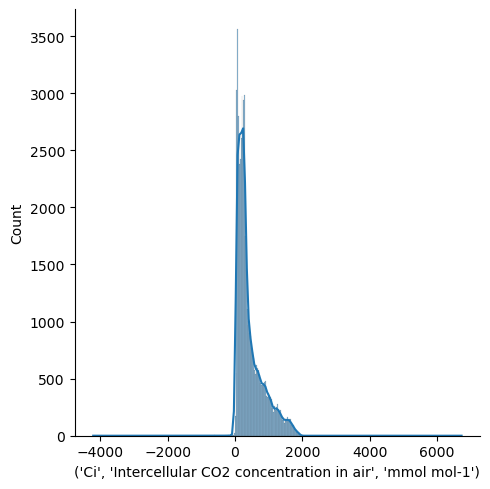

Visualizing ('CO2r', 'CO2 concentration in wet air entering chamber', 'mmol mol-1')


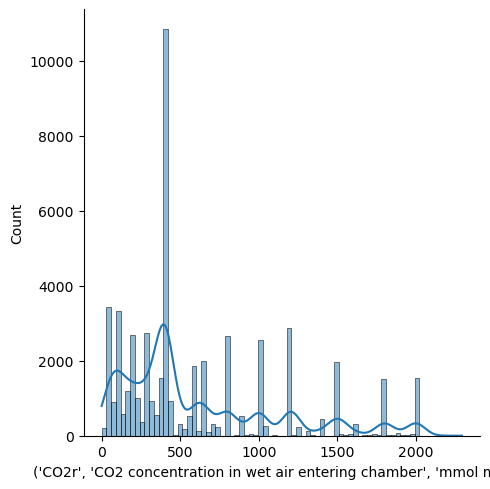

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'mmol mol-1')


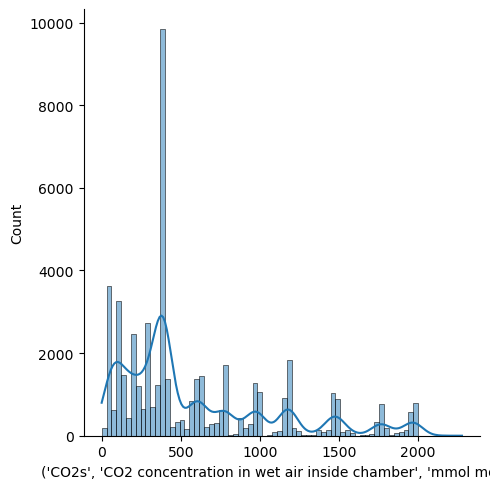

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


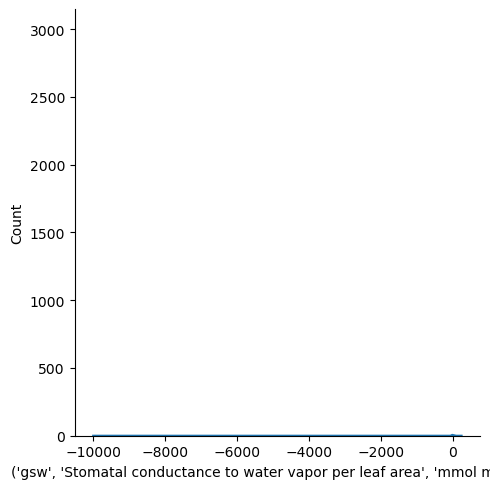

Visualizing ('dataContributor', 'Name of the individual or organization that contributed to the data', 1)


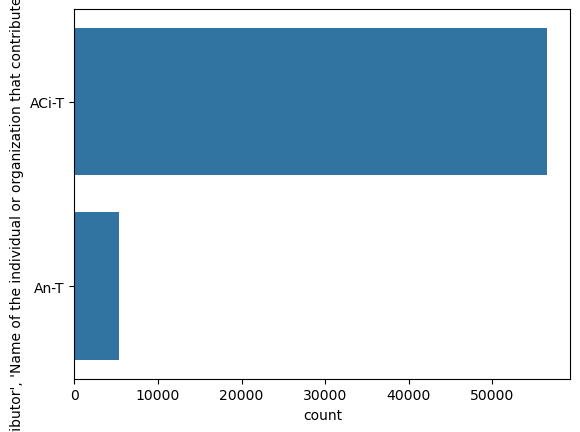

Visualizing ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1)


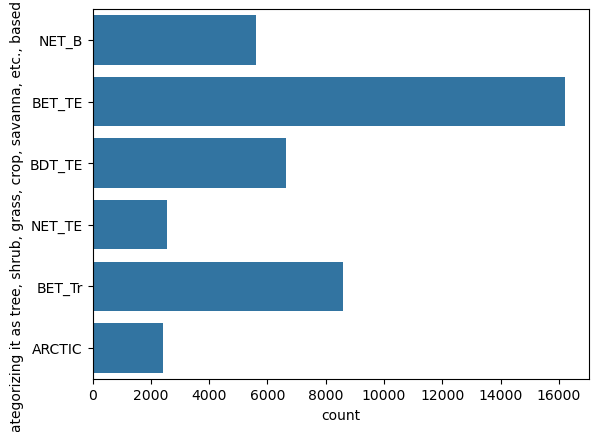

Visualizing ('A', 'Net CO2 exchange per leaf area', 'mmol m-2 s-1')


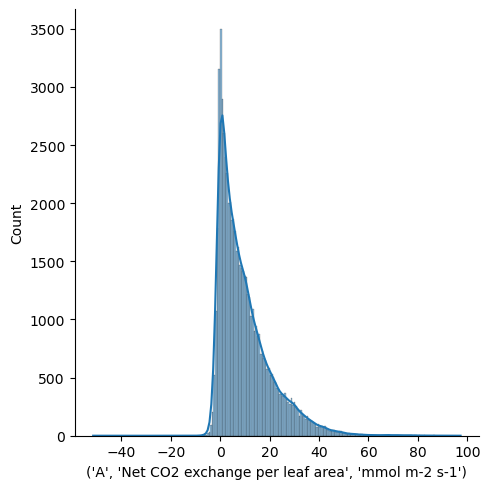

Visualizing ('Tair', 'Air temperature inside the chamber', 'degree_C')


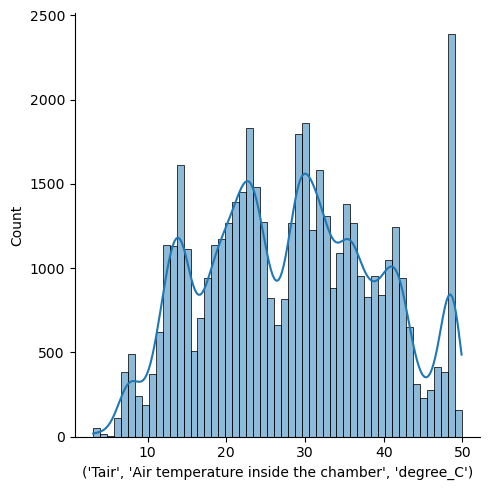

Visualizing ('Tblock', 'Temperature of cooler block used to stabilize air temperature', 'degree_C')


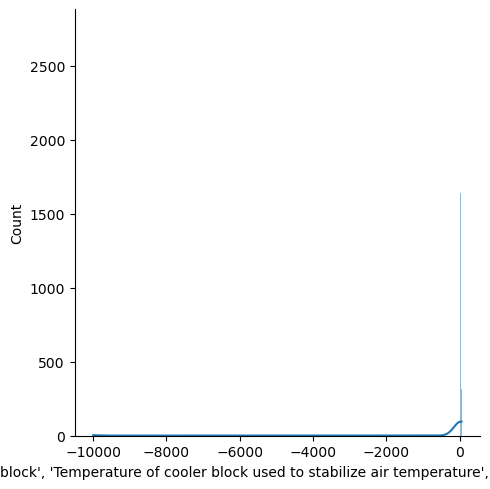

Visualizing ('Tleaf', 'Leaf surface temperature', 'degree_C')


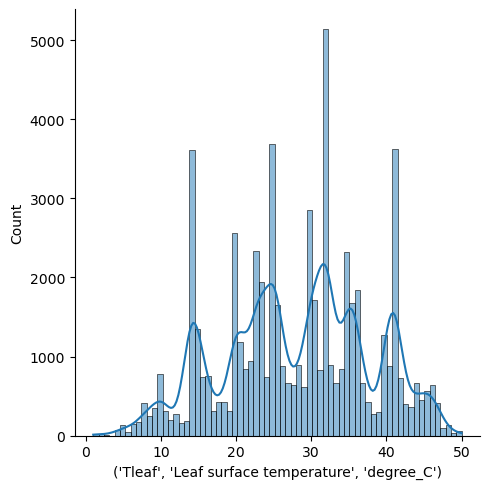

Visualizing ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa')


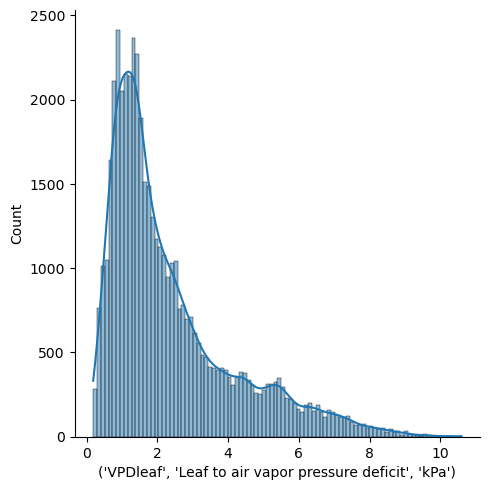

Visualizing ('experimentalManipulation', 'Experimental treatment(s) applied to the plant', 1)


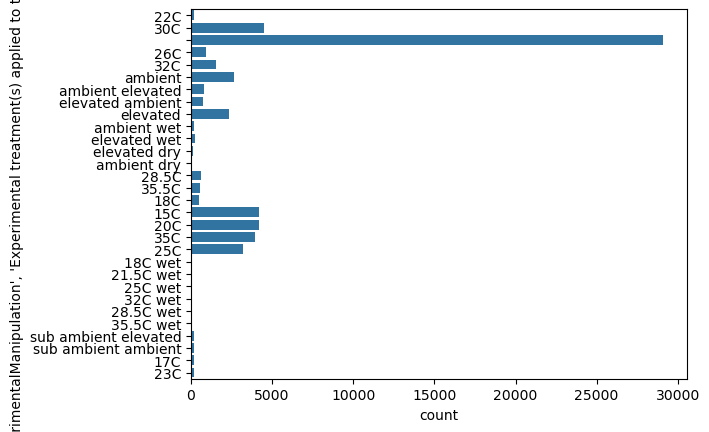

In [63]:
# Iterate over filtered_standard_data columns and visualize
for col in filtered_standard_data.columns:
    print(f"Visualizing {col}")
    funcs.visualize_all_columns(filtered_standard_data[col])

---
---
## 4. Quality Control

---
### 4.1. Strings

In [64]:
# general string cleaning
def clean_string_columns(df):
    # Select only object (string) dtype columns
    string_columns = df.select_dtypes(include=['object']).columns
    df.loc[:, string_columns] = df.loc[:, string_columns].apply(lambda col: col.str.strip().str.lower().str.replace('_', ' '))
    return df

# Apply the function to your DataFrame
filtered_standard_data = clean_string_columns(filtered_standard_data)